### Logistic regression - bank data

In [210]:
#importing libraries

import pandas as pd
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import classification_report

In [160]:
#reading data 

df=pd.read_csv("Bank.csv")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [161]:
#splitting only categorical data from  data frame df

df_cat=df.drop(['age','balance','duration'],axis=1)
df_cat.head()

,job,marital,education,default,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,Target
0,management,married,tertiary,no,yes,no,unknown,5,may,1,-1,0,unknown,no
1,technician,single,secondary,no,yes,no,unknown,5,may,1,-1,0,unknown,no
2,entrepreneur,married,secondary,no,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,blue-collar,married,unknown,no,yes,no,unknown,5,may,1,-1,0,unknown,no
4,unknown,single,unknown,no,no,no,unknown,5,may,1,-1,0,unknown,no


In [162]:
#taking only continuos data from the dataframe df 

df_con=df[['age','balance','duration']]
df_con.head()

,age,balance,duration
0,58,2143,261
1,44,29,151
2,33,2,76
3,47,1506,92
4,33,1,198


In [163]:
#data analysis for continuous data


def descriptive_stats(df_con):
    result=[]
    for col in list(df_con.columns):
        stats=OrderedDict({'feature_name':col,'count':df[col].count(),'minimum':df[col].min(),'Q1':df[col].quantile(0.25),
                                'mean':df[col].mean(),'median':df[col].median(),'Q3':df[col].quantile(0.75),'Maximum':df[col].max(),
                              'variance':round(df[col].var(),2),'sd':round(df[col].std(),2),'kurtosis':round(df_con[col].kurt(),2),'skewness':round(df_con[col].skew(),2)})
        result.append(stats)
        if df_con[col].skew()<-1:
            sk_label='Highly negatively skewed'
        elif -1 <=df_con[col].skew()<-0.5:
            sk_label='moderately negatively skewed'
        elif -0.5 <=df_con[col].skew()<0:
            sk_label='fairly negatively skewed(normal distribution)'
        elif 0<=df_con[col].skew()<0.5:
            sk_label='fairly positive skewed(normal distribution)'
        elif 0.5<=df_con[col].skew()<1:
            sk_label='moderately positively skewed'
        elif df_con[col].skew()>1:
            sk_label='highly positively skewed'
        else:
            sk_label='error'
        stats.update({'skewness_status':sk_label})
        des_stat=pd.DataFrame(result)
    return des_stat

In [164]:
descriptive_stats(df_con)

,feature_name,count,minimum,Q1,mean,median,Q3,Maximum,variance,sd,kurtosis,skewness,skewness_status
0,age,45211,18,33.0,40.936210,39.0,48.0,95,112.76,10.62,0.32,0.68,moderately positively skewed
1,balance,45211,-8019,72.0,1362.272058,448.0,1428.0,102127,9270598.95,3044.77,140.75,8.36,highly positively skewed
2,duration,45211,0,103.0,258.163080,180.0,319.0,4918,66320.57,257.53,18.15,3.14,highly positively skewed


### Outlier treatment

In [165]:
#copying continuous data df_con to another dataframe df_con1 .
#eliminating outliers in df_con1 and using the data df_con1 for further analysis 
df_con1=df_con.copy()
df_con1.shape


(45211, 3)

In [166]:
#outlier treatment for dataframe df_con1

for col in df_con.columns:
    median_value=df_con[col].median()
    iqr=df_con[col].quantile(0.75)-df_con[col].quantile(0.25)
    upper_limit=df_con[col].quantile(0.75)+(1.5*iqr)
    lower_limit=df_con[col].quantile(0.25)-abs(1.5*iqr)
    df_con1.loc[(df_con1[col]<lower_limit)|(df_con1[col]>upper_limit),col]=median_value
    
    


In [167]:
#analyse descriptive statistics after outlier treatment(changes in skewness values)
descriptive_stats(df_con1)

,feature_name,count,minimum,Q1,mean,median,Q3,Maximum,variance,sd,kurtosis,skewness,skewness_status
0,age,45211,18,33.0,40.936210,39.0,48.0,95,112.76,10.62,-0.65,0.42,fairly positive skewed(normal distribution)
1,balance,45211,-8019,72.0,1362.272058,448.0,1428.0,102127,9270598.95,3044.77,1.91,1.43,highly positively skewed
2,duration,45211,0,103.0,258.163080,180.0,319.0,4918,66320.57,257.53,0.79,1.09,highly positively skewed


In [213]:
#graph before and after outlier treatment
def outlier_treatment_plot(df_con,df_con1,col):
    f,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(30,8))

    #plot1 having dist plot with ouliers 
    sns.distplot(df_con[col],ax=ax1)
    ax1.set_title('distplot for ' + col + ' with ouliers')
    ax1.axvline(df_con[col].median(),color='green',linestyle='dashed')
    ax1.axvline(df_con[col].mean(),color='red')

    #plot2  having dist plot after outliers treatment
    sns.distplot(df_con1[col],ax=ax2)
    ax2.set_title('distplot for ' + col + ' after ouliers')
    ax2.axvline(df_con1[col].mean(),color='red')
    ax2.axvline(df_con1[col].median(),color='green',linestyle='dashed')

    #plot3 having boxplot with outliers

    sns.boxplot(df_con[col],ax=ax3,orient='v')
    ax3.set_ylabel('density')
    ax3.set_title('boxplot for '+ col +' with outliers')

    #plot4 having boxplot after outlier treatment 

    sns.boxplot(df_con1[col],ax=ax4)
    ax4.set_ylabel('density')
    ax4.set_title('boxplot for '+ col +' after outliers')

### Data analysis after oulier treatment

C:\Users\janani\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\janani\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\janani\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or 

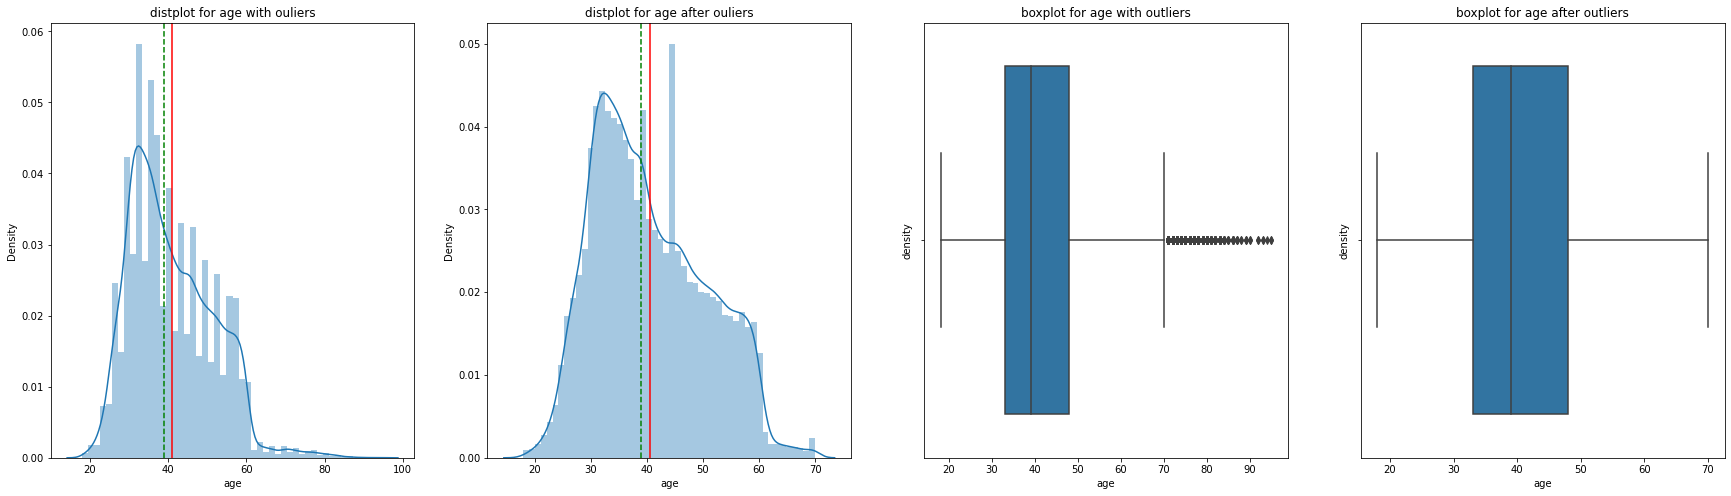

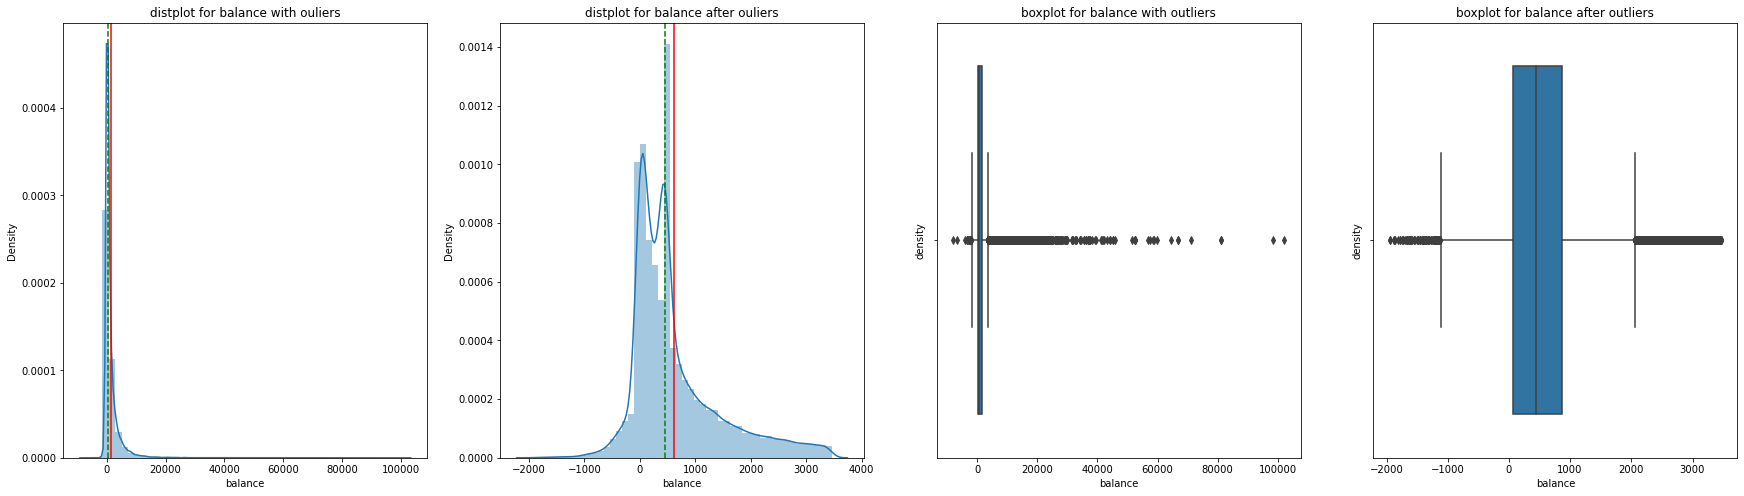

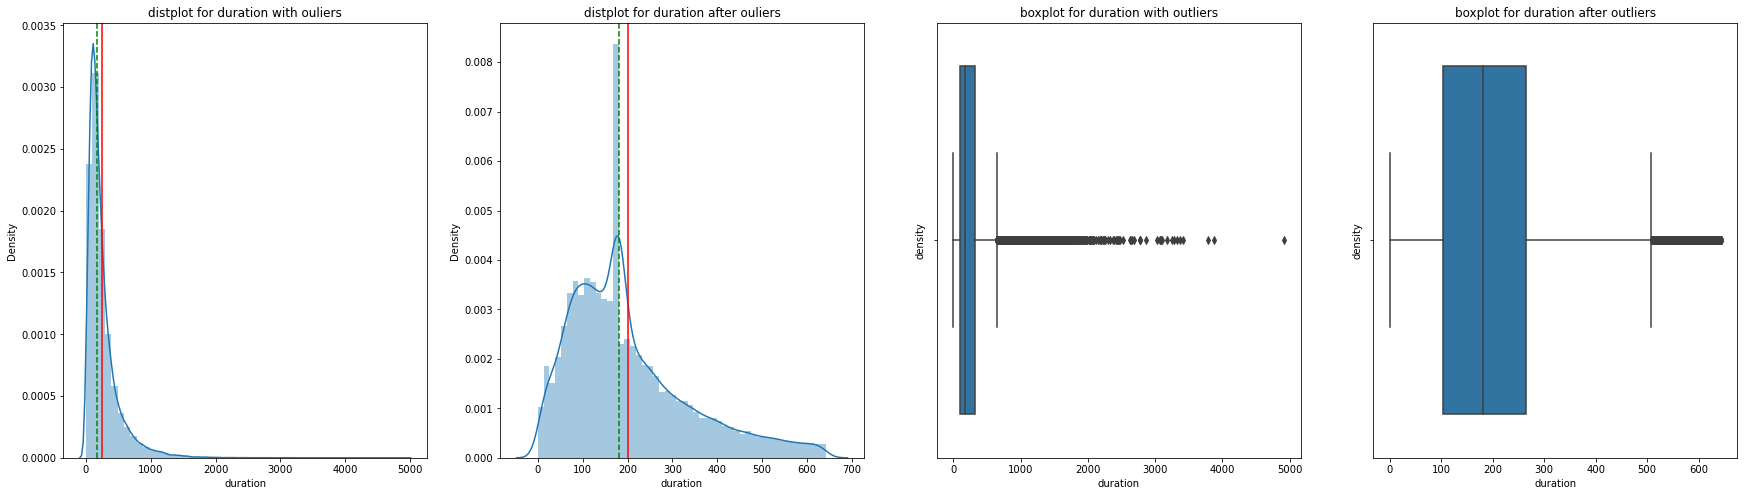

In [214]:
 for col in df_con.columns:
    outlier_treatment_plot(df_con,df_con1,col)

Text(0, 0.5, 'density')

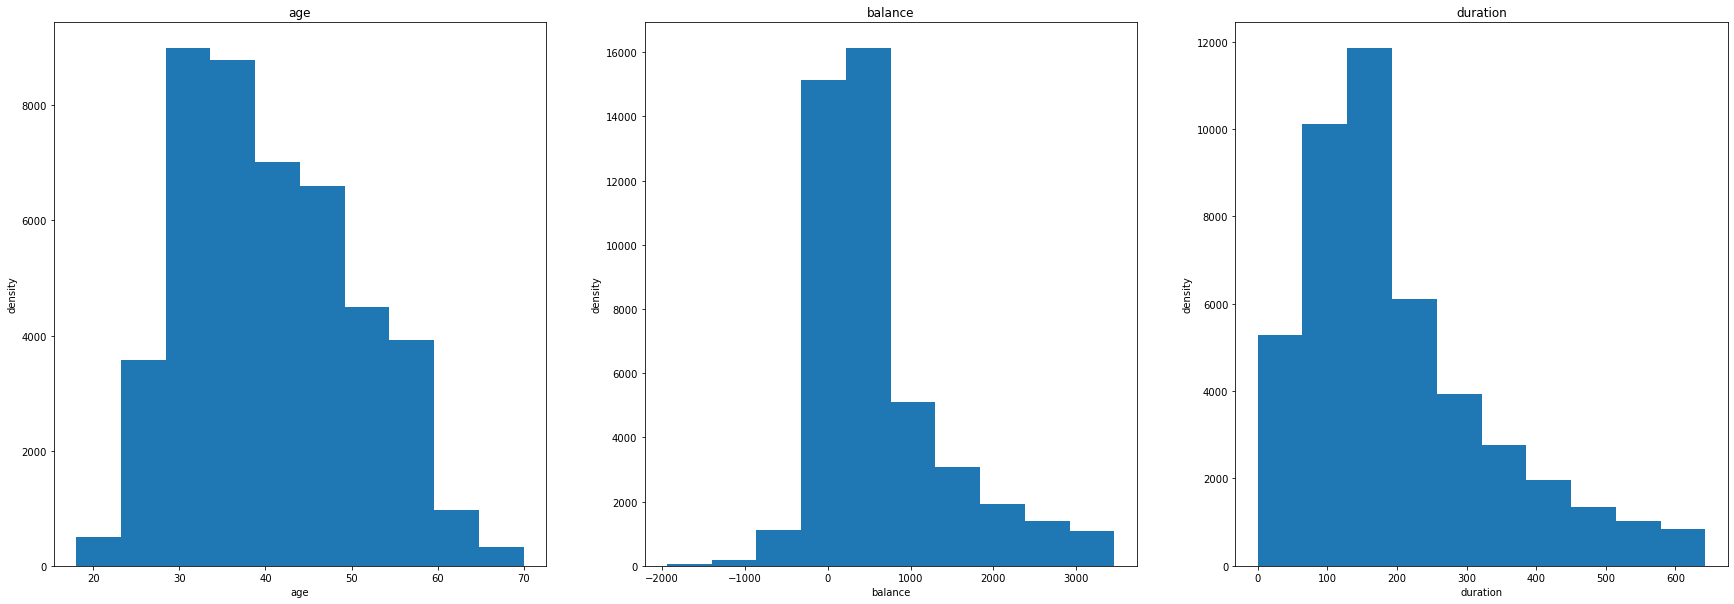

In [170]:

f,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(30,10))
ax1.hist(df_con1['age'])
ax1.set_title('age')
ax1.set_xlabel('age')
ax1.set_ylabel('density')


ax2.hist(df_con1['balance'])
ax2.set_title('balance')
ax2.set_xlabel('balance')
ax2.set_ylabel('density')

ax3.hist(df_con1['duration'])
ax3.set_title('duration')
ax3.set_xlabel('duration')
ax3.set_ylabel('density')


In [171]:
def plot(df_cat,col):
    #col='job'
    f,(ax1)=plt.subplots(1,1,figsize=(30,10))
    ax1.hist(df_cat[col])
    ax1.set_title(col)
    ax1.set_xlabel(col)
    ax1.set_ylabel('density')

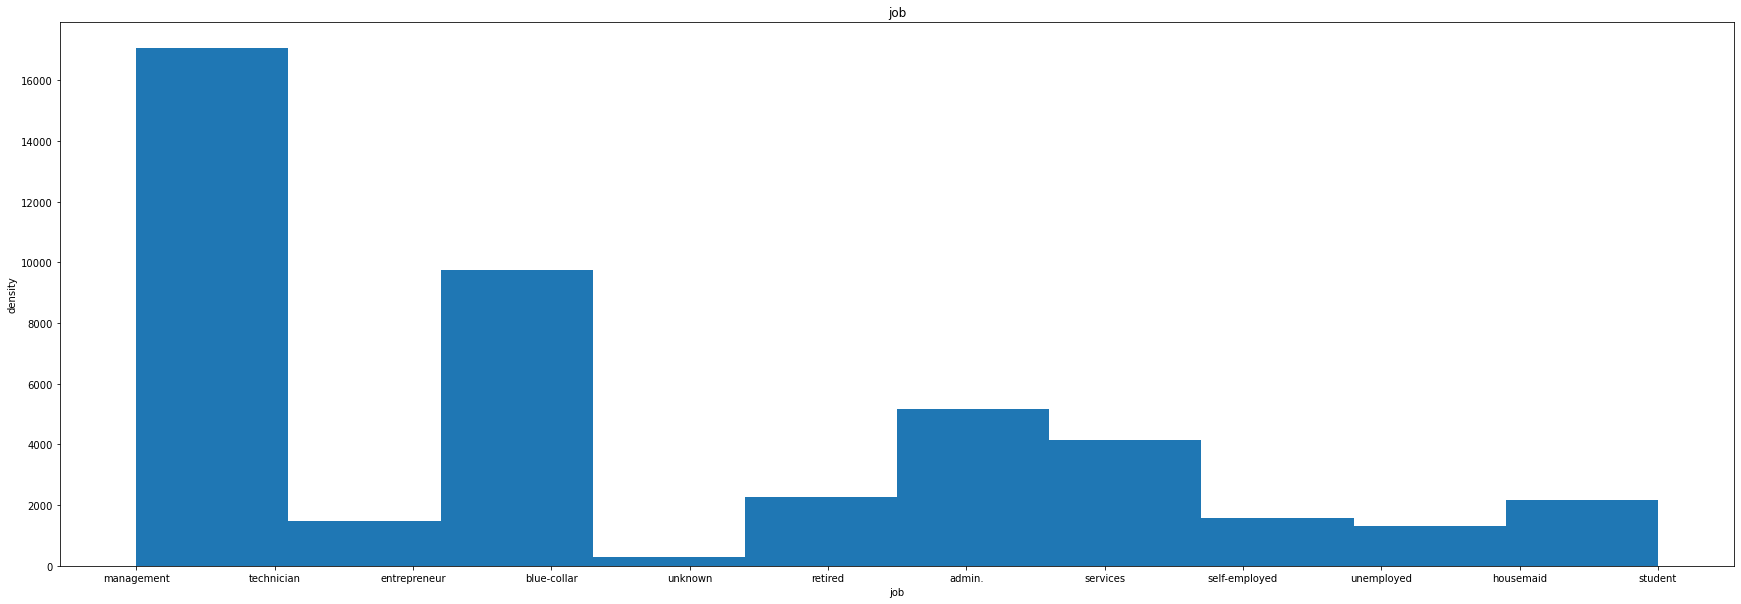

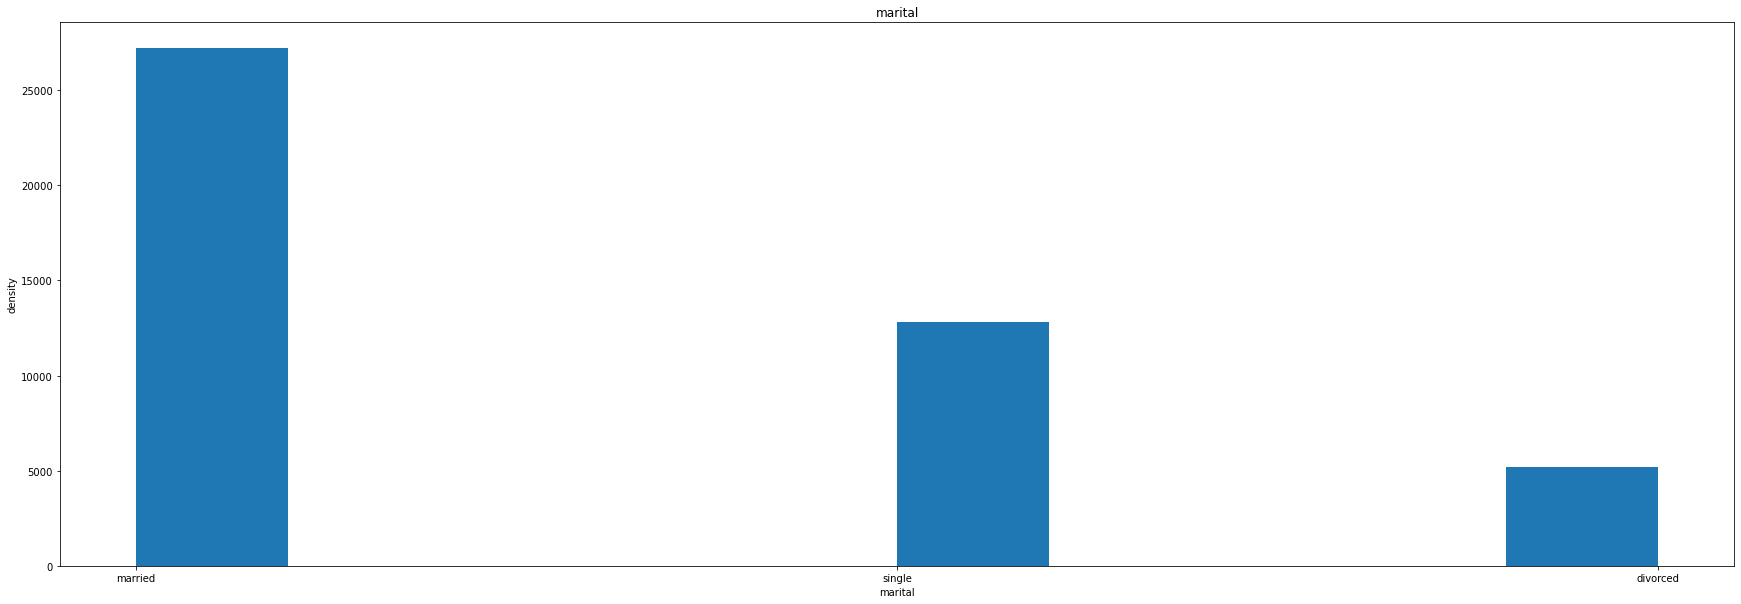

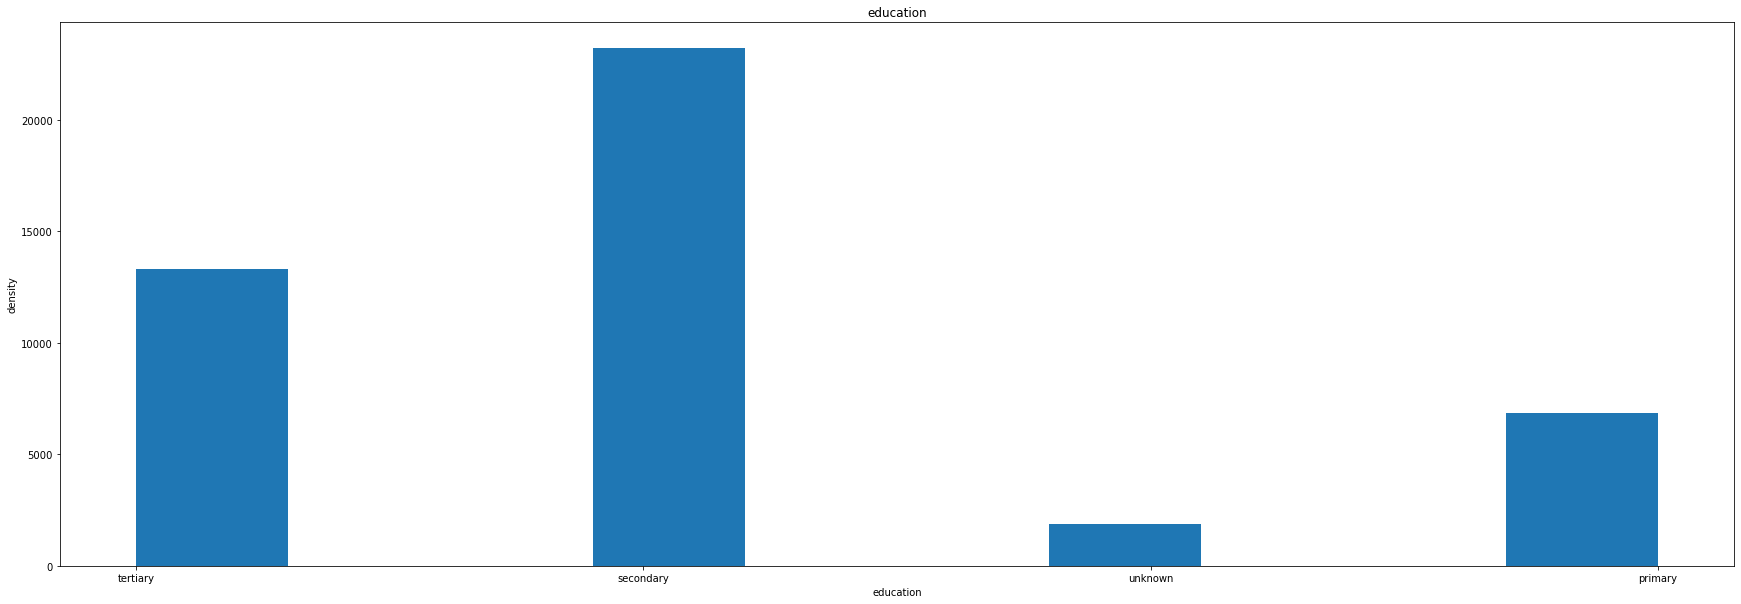

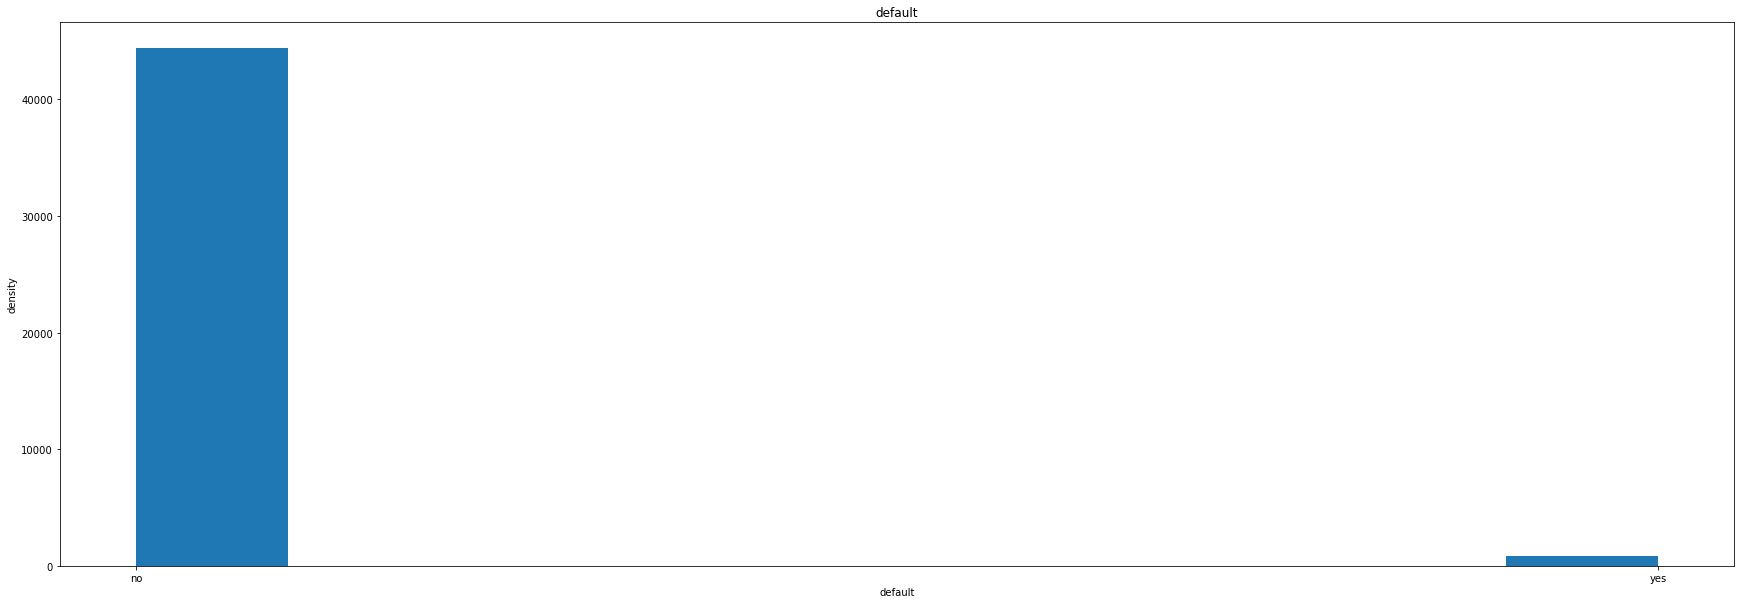

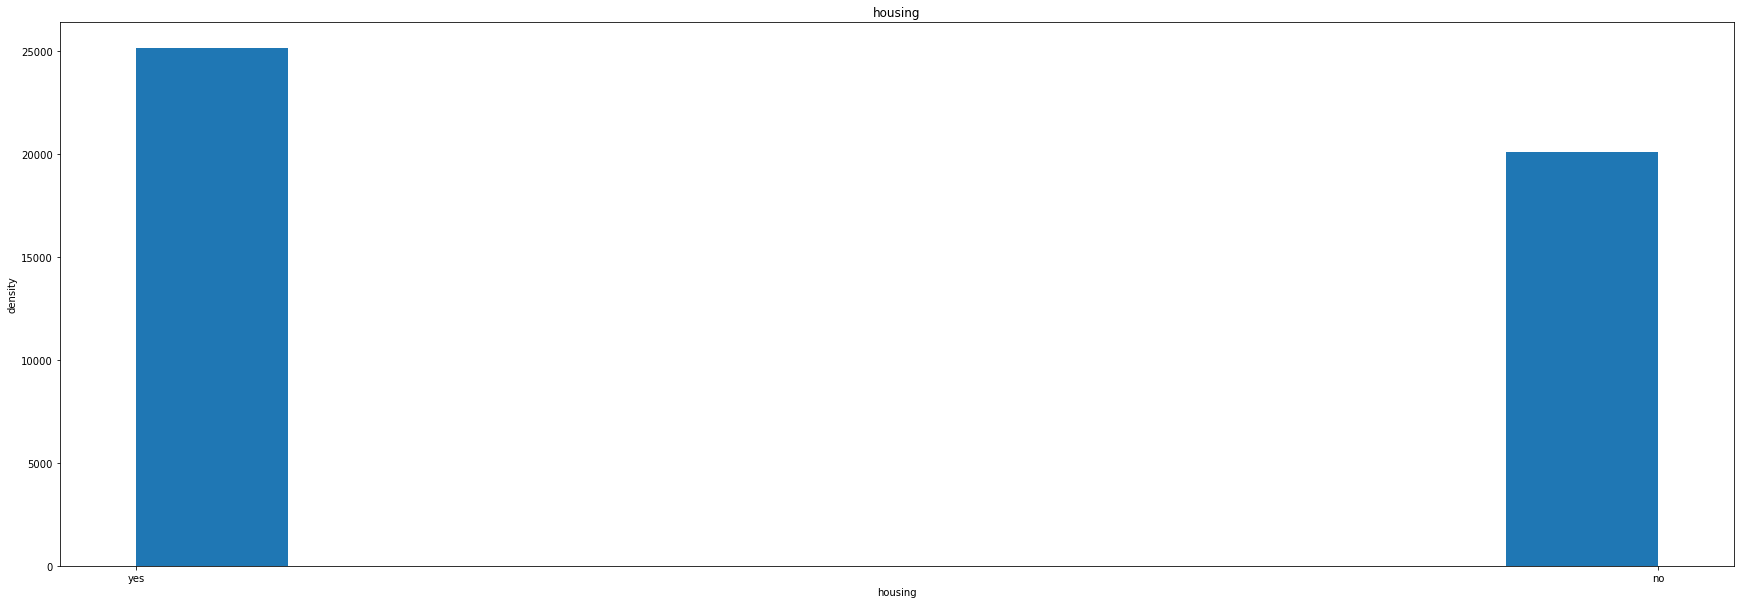

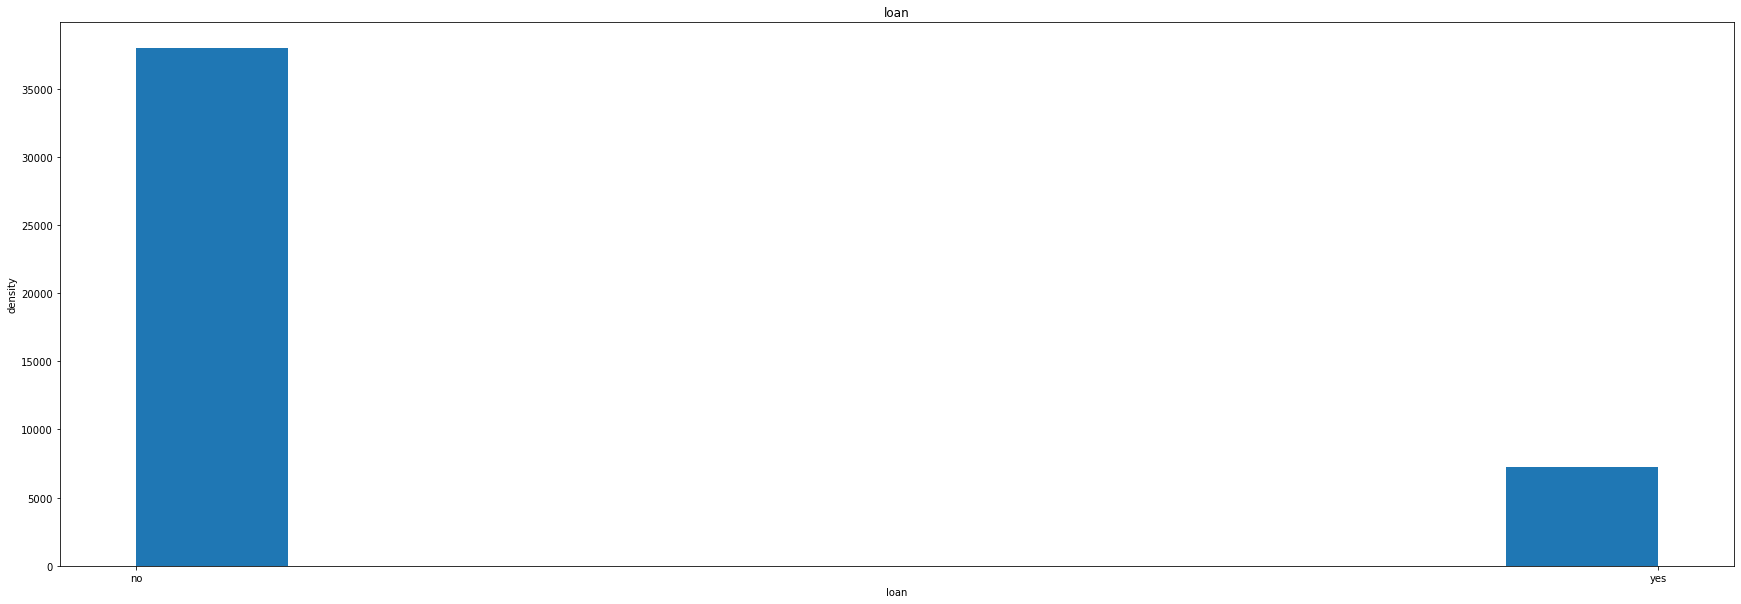

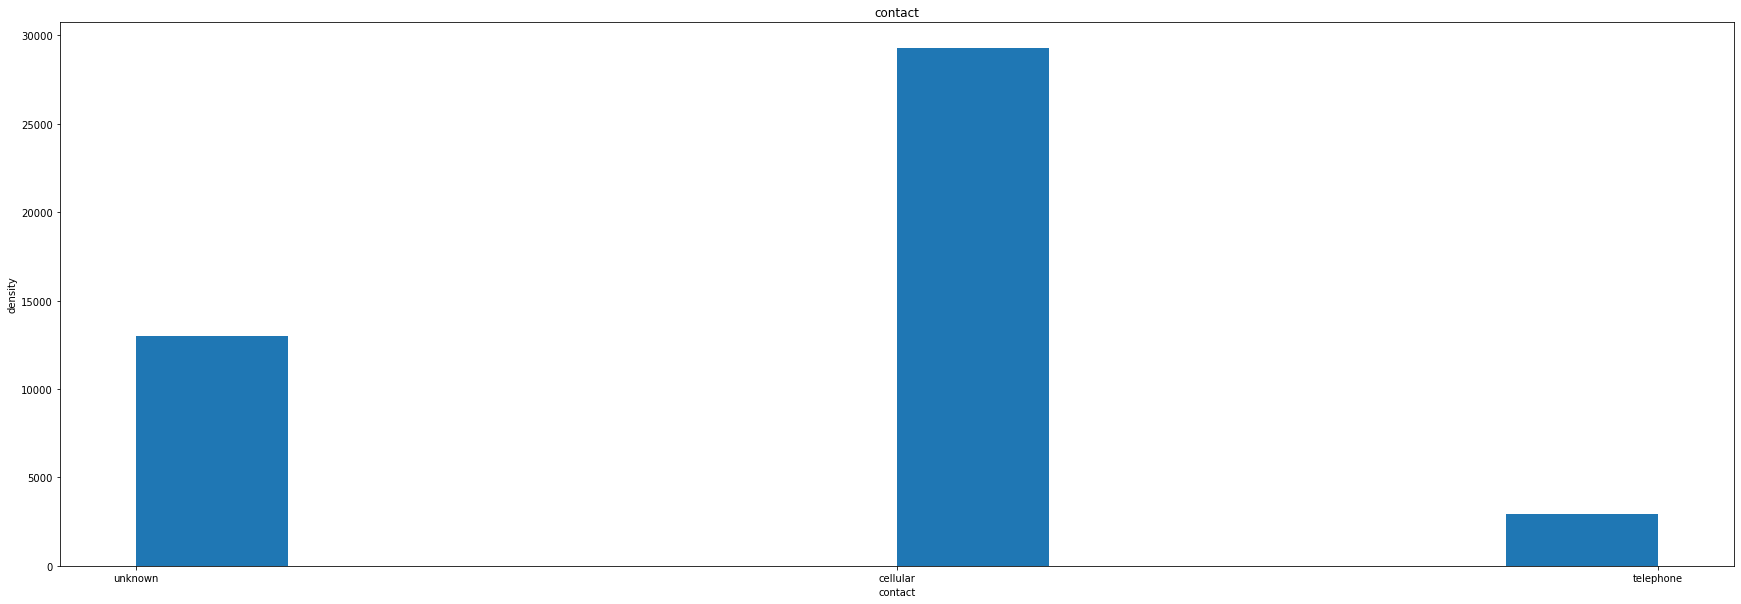

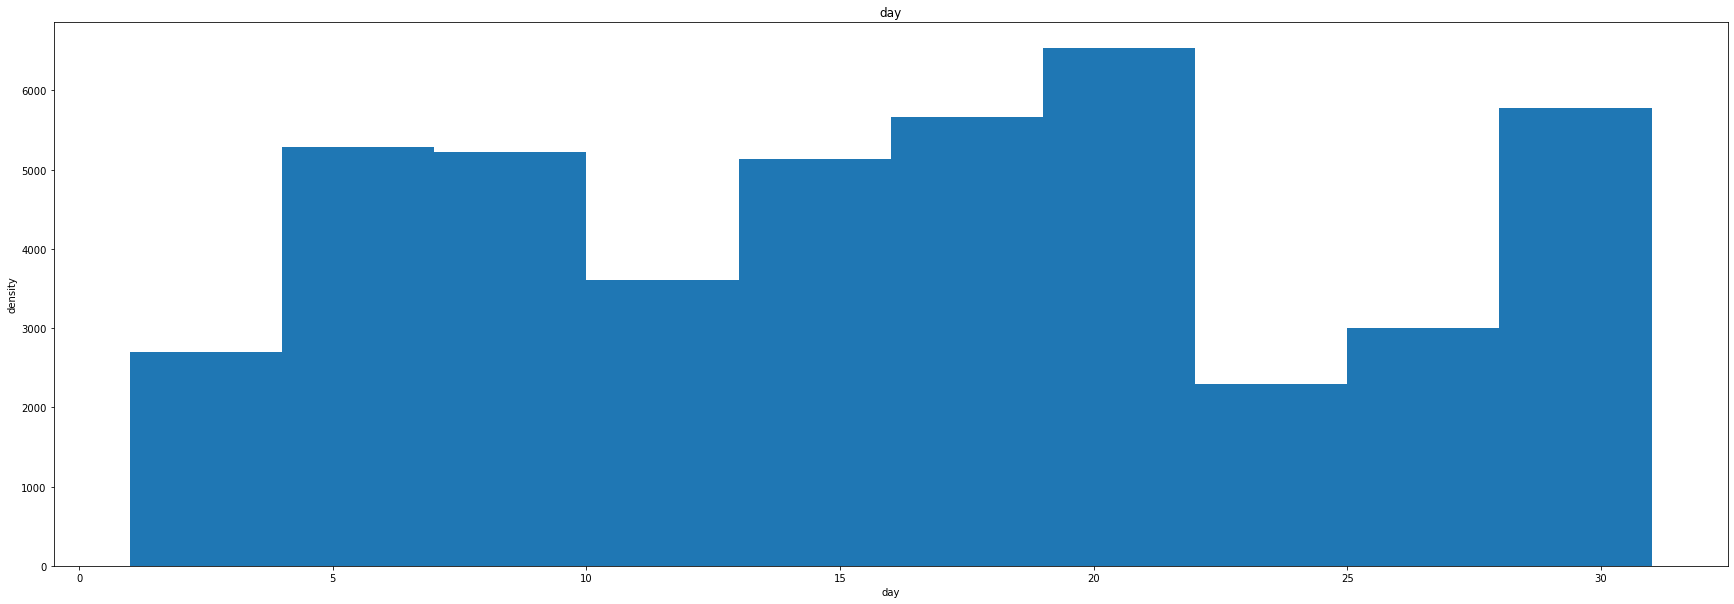

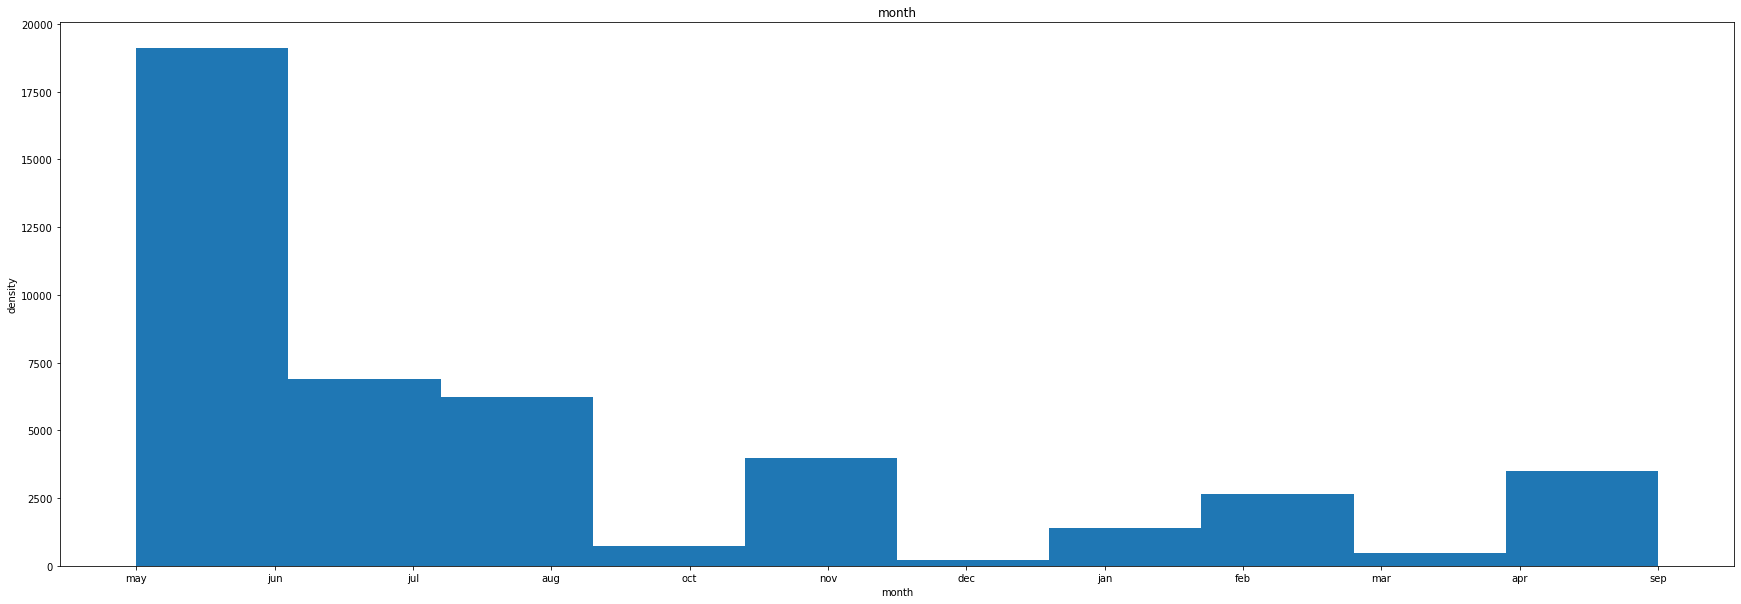

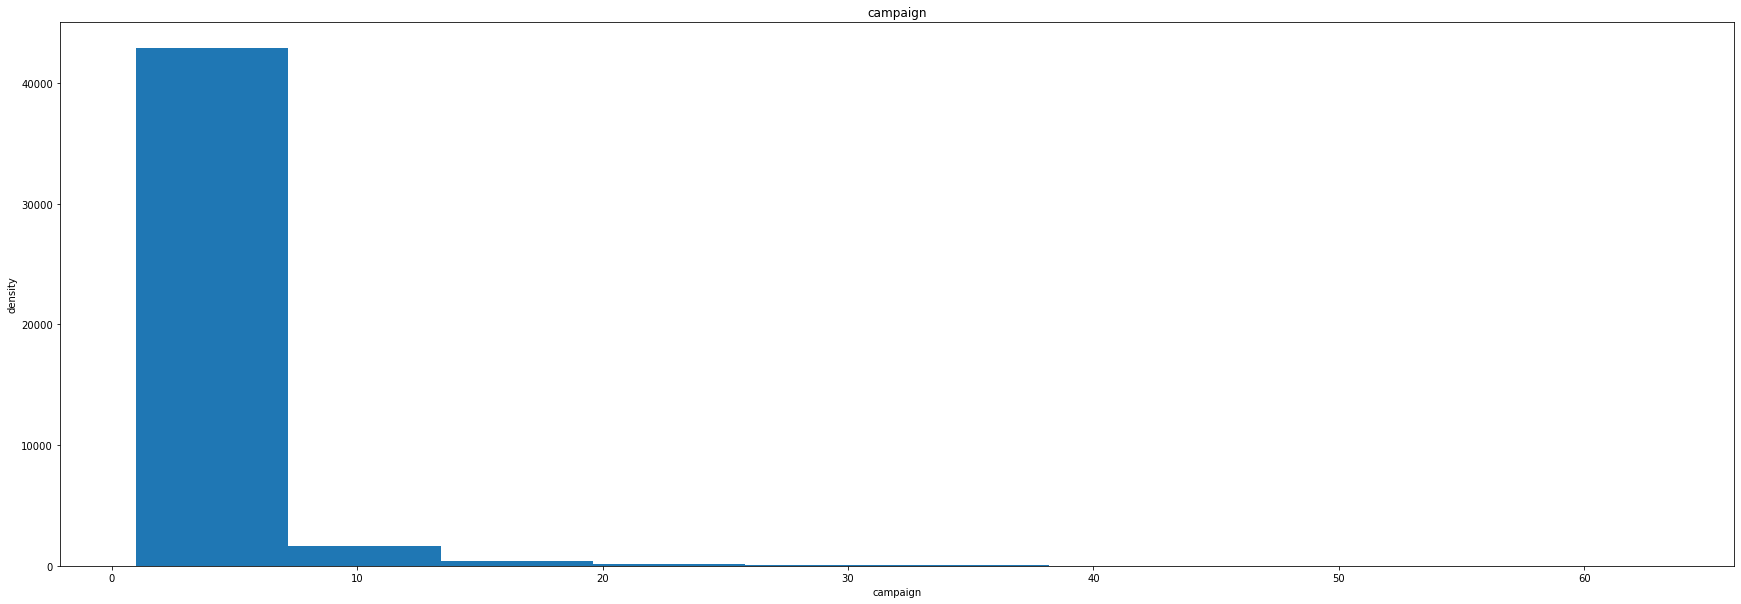

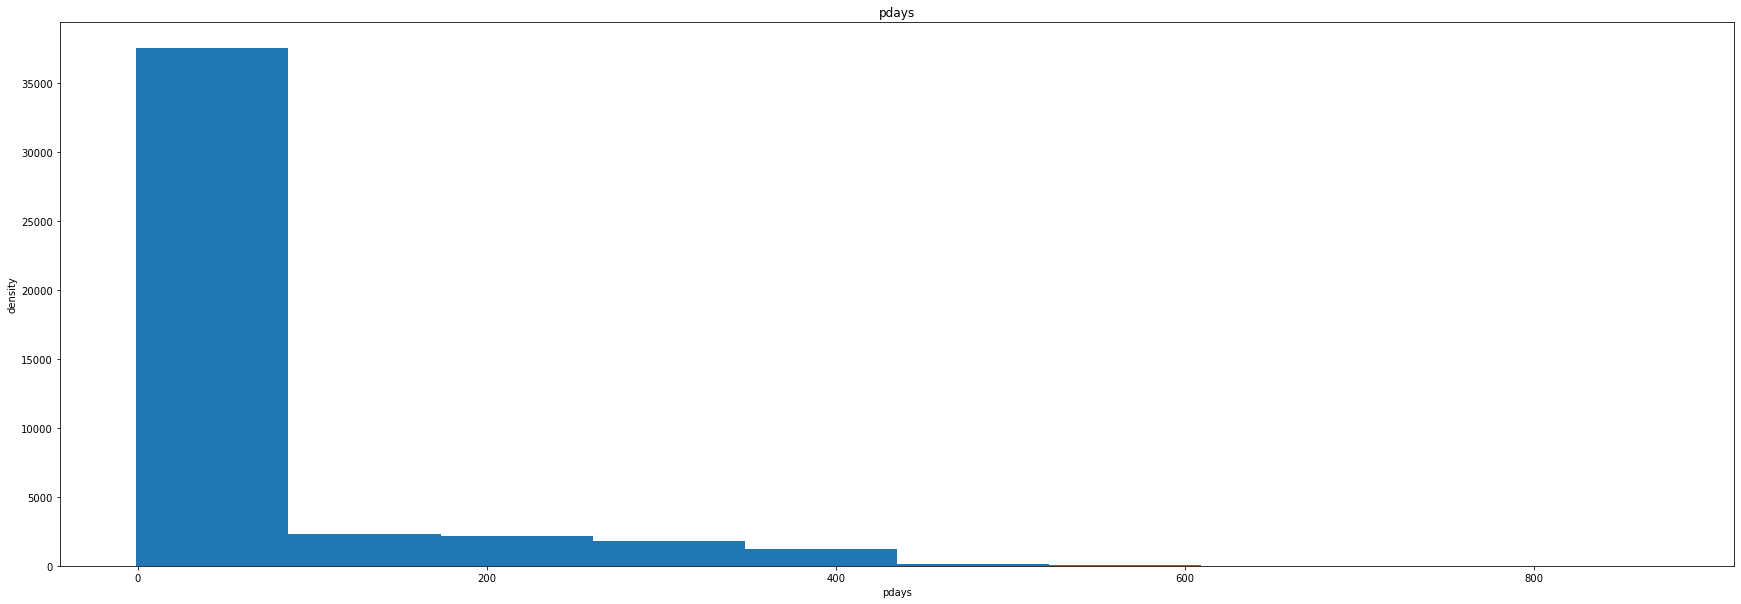

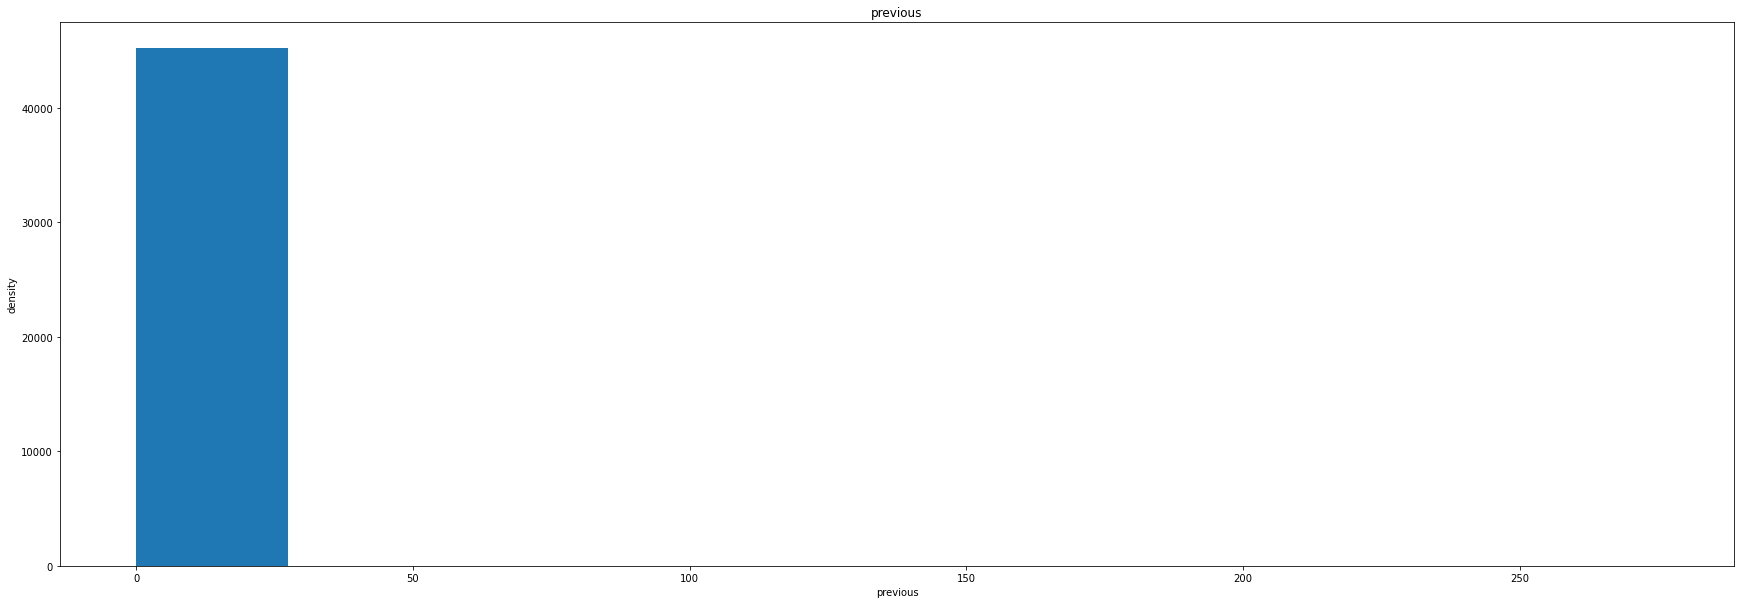

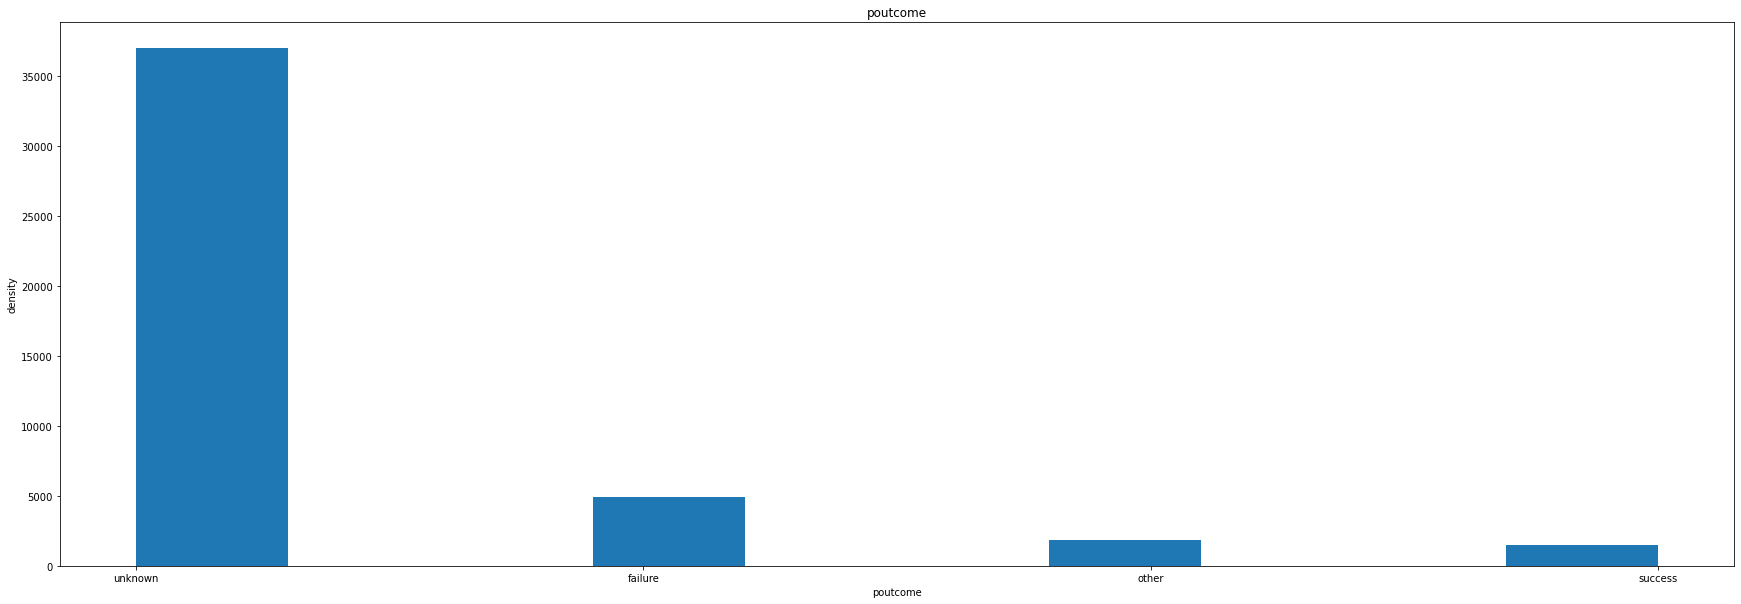

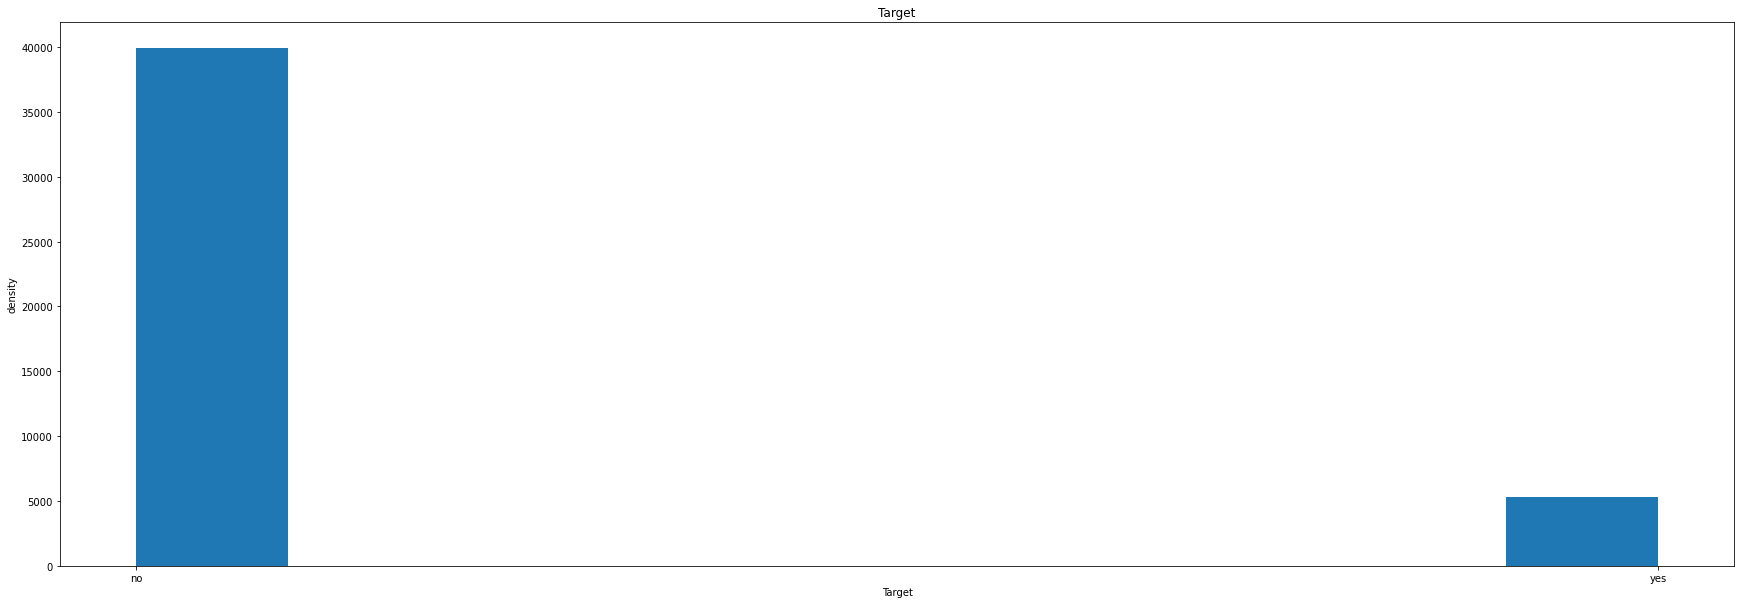

In [172]:
for col in df_cat.columns:
    plot(df_cat,col)

### Relationship Study

<AxesSubplot:>

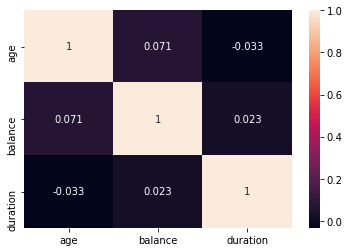

In [173]:
#heatmap for understanding correlation between independent variables.
correlation=df_con1.corr()
sns.heatmap(correlation,annot=True)

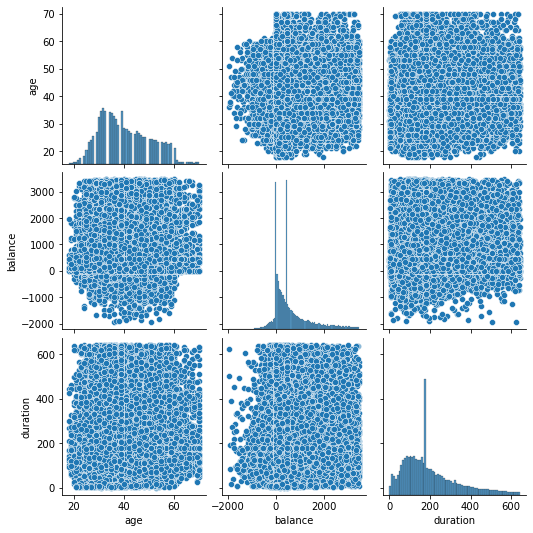

In [174]:
sns.pairplot(df_con1)

#### Model building

In [175]:
df_con1.head()

,age,balance,duration
0,58,2143,261
1,44,29,151
2,33,2,76
3,47,1506,92
4,33,1,198


In [179]:
df_cat.columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'day', 'month', 'campaign', 'pdays', 'previous', 'poutcome', 'Target'],
      dtype='object')

In [182]:
le=LabelEncoder()
df_cat['job']=le.fit_transform(df_cat['job'])
df_cat['marital']=le.fit_transform(df_cat['marital'])
df_cat['education']=le.fit_transform(df_cat['education'])
df_cat['default']=le.fit_transform(df_cat['default'])
df_cat['housing']=le.fit_transform(df_cat['housing'])
df_cat['loan']=le.fit_transform(df_cat['loan'])
df_cat['contact']=le.fit_transform(df_cat['contact'])
df_cat['day']=le.fit_transform(df_cat['day'])
df_cat['month']=le.fit_transform(df_cat['month'])
df_cat['campaign']=le.fit_transform(df_cat['campaign'])
df_cat['pdays']=le.fit_transform(df_cat['pdays'])
df_cat['previous']=le.fit_transform(df_cat['previous'])
df_cat['poutcome']=le.fit_transform(df_cat['poutcome'])
df_cat['Target']=le.fit_transform(df_cat['Target'])



In [183]:
df_cat.head()

,job,marital,education,default,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,Target
0,4,1,2,0,1,0,2,4,8,0,0,0,3,0
1,9,2,1,0,1,0,2,4,8,0,0,0,3,0
2,2,1,1,0,1,1,2,4,8,0,0,0,3,0
3,1,1,3,0,1,0,2,4,8,0,0,0,3,0
4,11,2,3,0,0,0,2,4,8,0,0,0,3,0


In [184]:
df_log=pd.concat([df_con1,df_cat],axis=1)
df_log.head()

,age,balance,duration,job,marital,education,default,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,Target
0,58,2143,261,4,1,2,0,1,0,2,4,8,0,0,0,3,0
1,44,29,151,9,2,1,0,1,0,2,4,8,0,0,0,3,0
2,33,2,76,2,1,1,0,1,1,2,4,8,0,0,0,3,0
3,47,1506,92,1,1,3,0,1,0,2,4,8,0,0,0,3,0
4,33,1,198,11,2,3,0,0,0,2,4,8,0,0,0,3,0


In [194]:
x=df_log.iloc[:,0:16]
y=df_log.iloc[:,16:17]

In [195]:
x.head()

,Target
0,0
1,0
2,0
3,0
4,0


In [196]:
y.head()

,Target
0,0
1,0
2,0
3,0
4,0


In [199]:
lr=LogisticRegression()
model_fit=lr.fit(x,y)
y_predict=model_fit.predict(x)

C:\Users\janani\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\janani\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Model evaluation

In [205]:
print('accuracy of the model is', accuracy_score(y,y_predict)*100)

accuracy of the model is 88.19977439118799


In [211]:
# confusion matrix
matrix = confusion_matrix(y,y_predict, labels=[1,0])
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(y,y_predict,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y,y_predict,labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[  122  5167]
 [  168 39754]]
Outcome values : 
 122 5167 168 39754
Classification report : 
               precision    recall  f1-score   support

           1       0.42      0.02      0.04      5289
           0       0.88      1.00      0.94     39922

    accuracy                           0.88     45211
   macro avg       0.65      0.51      0.49     45211
weighted avg       0.83      0.88      0.83     45211

